### Exercise 1: Modeling Memory Decay

Here I've provided a sample sanitized dataset that can be used to develop a general model of memory decay, and performance over time. The primary aim would be to predict the likely accuracy of a test of a given type, for a given user, at a given (future) moment in time. That's important since it allows you to schedule reviews at the [optimal time for learning](https://en.wikipedia.org/wiki/Desirable_difficulty).

A second and in some ways more challenging aim would be to be able to summarize the ability of a given user, the strength of a given memory, or the difficulty of a given item, with a stable and interpretable metric. That, for example, might lead you away from some out-of-the-box machine learning techniques like neural nets and random forests, and instead towards more scientifically constrained and carefully structured models.

This is left as an exercise to the interested reader, but I'll offer some additional pointers:

- It's worth taking a quick dive into the learning science literature to get a sense of the factors that should affect learning. Some important relevant ones for this dataset include the number, type and timing of tests. 
- If you take the approach of training a neural net or a random forest, consider how to structure the input features: The data are a little more complex than the existing columns imply. How do you effectively represent the entire history of a memory? The particular number and combination of tests, outcomes, and spacing between them?
- If you take the approach of updating a more scientifically inspired decay model, what form should that take? A quick hint here is that while a lot of people in the space use exponential decay, there are strong reasons to believe that's not very accurate. One intuitive reason: exponential decay is memoryless, in the sense that surviving memories would be no less likely to decay over the next time period. Consolidation and selection bias would suggest this is an unlikely property for the decay curve.
- Be aware that the decay function for a memory is changing over time. Each event (review test) measures the underlying memory state, but also changes it, and so a naive error-correction approach would leave you immediately, and always, out of date. _Future_ accuracy for a memory is more important than _current_ accuracy.
- A simple first step might be to create a general model (not personalized to each learner). It's important to bear in mind though that big confounds and selection biases lie with this approach, since the users contributing many reviews over a longer time period probably show some differences with those who study once and drop out early.
- Building a model from static data is one thing; how do we adjust it as new items, users and quiz types enter the system?

Which of these or additional constraints your model satisfies, its accuracy, and its generalizability, really all depend on the ultimate purpose. What's the output, who will use it, and for what? Giving me an optimal review time, showing me how well I understand something, and advancing cognitive science are all quite different applications with different requirements for the underlying analysis.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', palette='Set2')
path = '/Users/iainharlow/googledrive/GitHub/ds30/'

In [2]:
sample = pd.read_csv('cerego_sample.csv.zip')
sample[:10]

,Unnamed: 0,user,item,timestamp,quiz_type,result
0,0,312,267630,2017-03-28 11:33:20,study,NaN
1,1,42219,529201,2017-03-28 11:32:37,recognition,1.0
2,2,42219,529204,2017-03-28 11:32:45,recognition,1.0
3,3,42219,529205,2017-03-28 11:32:54,recognition,1.0
4,4,42219,474094,2017-03-28 11:33:06,recognition,1.0
5,12,41208,331062,2017-03-28 11:31:25,study,NaN
6,13,41208,331063,2017-03-28 11:31:44,study,NaN
7,14,41208,331064,2017-03-28 11:32:26,study,NaN
8,15,41208,331065,2017-03-28 11:32:52,study,NaN
9,16,41208,331066,2017-03-28 11:33:02,study,NaN


Let's take a look at the data, which constitute a simplified and sanitized sample from Cerego's database. We have rows of events, which are either a study (the first time a learner encounters an item) or a review of some type (when the learner tests themselves on something they're previously learned). We have five meaningful columns:

- **user** is a code denoting each unique user in the system
- **item** is a code denoting the specific item being learned
- **timestamp** denotes the moment the event happened
- **quiz_type** tells us whether it's a study, or if not, what category of review it is (recall is a productive test without options, recognition is generally a multiple choice of some kind, and multiple_answers questions have one or more correct responses which muct be selected to be completely correct).
- **result** is the outcome of the review, where 0.0 means the user was incorrect, 0.5 is partially correct, and 1.0 is correct. This is what we'd like to predict.

After having a go at predicting the results yourself, you might like to compare to a simple benchmark model, below. You can modify this simple code to check your own output in the same format. Be sure to reserve an unseen test sample to evaluate your model (in testing the model below I ran it against ~4 million recent reviews).

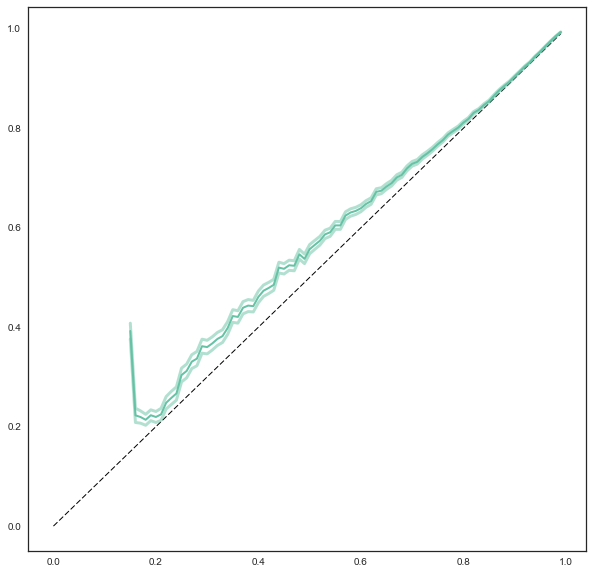

In [3]:
'''
Calibration. Plot the actual data against the predicted result.
The benchmark model here was run against a larger sample of around 4 million recent reviews.
The benchmark model here has a floor predicted accuracy of 0.15.
'''

data = pd.read_csv('benchmark.csv.zip')
data['sd'] = np.sqrt(data.result/data.reviews*(1-data.result))

sns.set(style='white', palette='Set2')
fig = plt.figure(figsize=(10,10))

plt.plot(np.arange(1,step=0.01),np.arange(1,step=0.01),lw=1,color='k',linestyle='--')
plt.plot(data.predicted,data.result-1.96*data.sd,lw=3,color='#65C2A5',alpha=0.5,linestyle='-')
plt.plot(data.predicted,data.result+1.96*data.sd,lw=3,color='#65C2A5',alpha=0.5,linestyle='-')
plt.plot(data.predicted,data.result,lw=2,color='#65C2A5')



In [4]:
'''
We can calculate some quick gut-check accuracy metrics.
'''

cutoff = 0.5

data['correct'] = data.reviews*data.result

TP = data[data.predicted>cutoff].correct.sum()
P = data.correct.sum()

TN = data[data.predicted<cutoff].reviews.sum() - data[data.predicted<cutoff].correct.sum()
N = data.reviews.sum() - data.correct.sum()

sensitivity = TP/P
specificity = TN/N

accuracy = (TP+TN)/(P+N)

print('accuracy:', accuracy)
print('sensitivity:', sensitivity)
print('specificity:', specificity)

accuracy: 0.852782159806
sensitivity: 0.971498066441
specificity: 0.210134704424


AUC: 0.779038176381


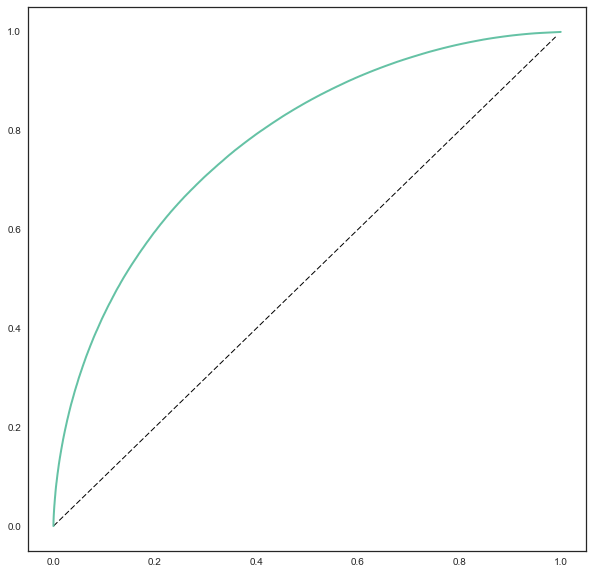

In [5]:
'''
Plot a ROC curve and calculate the AUC.
'''
from sklearn import metrics
fig = plt.figure(figsize=(10,10))

rocdata = pd.read_csv('benchmark_fpr_tpr.csv.zip') # contains our false positive and true positive rates
fpr = rocdata.fpr
tpr = rocdata.tpr
auc = metrics.auc(fpr,tpr)
print('AUC:',auc)

plt.plot(np.arange(1,step=0.01),np.arange(1,step=0.01),lw=1,color='k',linestyle='--')
plt.plot(fpr,tpr,lw=2,color='#65C2A5')
